In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from IPython.core.display import display, HTML
import os
%matplotlib inline

In [2]:
# Notebook Styling 
sns.set()
pd.options.display.max_columns = None
# display(HTML("<style>.container { width:100% !important; }</style>"))

The data set below is available on this [City of Chicago Data Portal page](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), but as the file is approximately 1 GB, I've excluded it from this repo.

[Chicago Community Area Geojson](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

[Chicago Police Beat Geojson](https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-current-/aerh-rz74)

[Chicago 2010 Census Block Geojson](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Blocks-2010/mfzt-js4n)

In [3]:
CSV_PATH = os.path.join('data', 'ChicagoCrimes_2001_to_present.csv')
chi_crimes = pd.read_csv(CSV_PATH, encoding='latin1') 
chi_crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,03/18/2015 07:44:00 PM,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,"(41.891398861, -87.744384567)"
1,10000094,HY190059,03/18/2015 11:00:00 PM,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,"(41.773371528, -87.665319468)"
2,10000095,HY190052,03/18/2015 10:45:00 PM,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,08B,1185075.0,1875622.0,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,"(41.81386068, -87.596642837)"
3,10000096,HY190054,03/18/2015 10:30:00 PM,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,2.0,3.0,40.0,08B,1178033.0,1870804.0,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,"(41.800802415, -87.622619343)"
4,10000097,HY189976,03/18/2015 09:00:00 PM,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,11.0,28.0,25.0,03,1144920.0,1898709.0,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354,"(41.878064761, -87.743354013)"


In [4]:
chi_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6673140 entries, 0 to 6673139
Data columns (total 22 columns):
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Location                object
dtypes: bool(2), float64(7), int64(3), object(10)
memory usage: 1.0+ GB


We see that location is just a tuple containing the latitude and the longitude, and per the data description on the page linked above, the X and Y coordinates are just the location in the State Plane Illinois East NAD 1983 map projection. 

In [5]:
chi_crimes.drop(['Location', 'X Coordinate', 'Y Coordinate'], axis=1, inplace=True)
chi_crimes.drop(['Case Number'], axis=1, inplace=True)

In [6]:
chi_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6673140 entries, 0 to 6673139
Data columns (total 18 columns):
ID                      int64
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
dtypes: bool(2), float64(5), int64(3), object(8)
memory usage: 827.3+ MB


In [7]:
date_format = '%m/%d/%Y %I:%M:%S %p'
chi_crimes['Date'] = pd.to_datetime(chi_crimes['Date'], format=date_format)

In [8]:
chi_crimes['Description'] = chi_crimes['Description'].astype('category')
chi_crimes['Primary Type'] = chi_crimes['Primary Type'].astype('category')

In [100]:
chi_crimes['Hour'] = chi_crimes['Date'].dt.hour
chi_crimes['Week'] = chi_crimes['Date'].dt.weekofyear
chi_crimes['Day'] = chi_crimes['Date'].dt.dayofyear
chi_crimes['Weekday'] = chi_crimes['Date'].dt.dayofweek
chi_crimes['Month'] = chi_crimes['Date'].dt.month

In [9]:
chi_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6673140 entries, 0 to 6673139
Data columns (total 18 columns):
ID                      int64
Date                    datetime64[ns]
Block                   object
IUCR                    object
Primary Type            category
Description             category
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
dtypes: bool(2), category(2), datetime64[ns](1), float64(5), int64(3), object(5)
memory usage: 744.6+ MB


In [10]:
chi_crimes['Date'].nunique()

2666199

In [11]:
chi_crimes['Date'].isnull().sum()

0

In [12]:
chi_crimes['Primary Type'].nunique()

35

In [13]:
chi_crimes['Primary Type'].unique()

[BATTERY, OTHER OFFENSE, ROBBERY, NARCOTICS, CRIMINAL DAMAGE, ..., NON - CRIMINAL, NON-CRIMINAL, RITUALISM, NON-CRIMINAL (SUBJECT SPECIFIED), DOMESTIC VIOLENCE]
Length: 35
Categories (35, object): [BATTERY, OTHER OFFENSE, ROBBERY, NARCOTICS, ..., NON-CRIMINAL, RITUALISM, NON-CRIMINAL (SUBJECT SPECIFIED), DOMESTIC VIOLENCE]

In [14]:
chi_crimes['Primary Type'].value_counts()

THEFT                                1399665
BATTERY                              1218668
CRIMINAL DAMAGE                       763837
NARCOTICS                             707157
OTHER OFFENSE                         414072
ASSAULT                               412902
BURGLARY                              384632
MOTOR VEHICLE THEFT                   311497
DECEPTIVE PRACTICE                    257010
ROBBERY                               252976
CRIMINAL TRESPASS                     191547
WEAPONS VIOLATION                      69137
PROSTITUTION                           68097
PUBLIC PEACE VIOLATION                 47418
OFFENSE INVOLVING CHILDREN             44670
CRIM SEXUAL ASSAULT                    26565
SEX OFFENSE                            24699
INTERFERENCE WITH PUBLIC OFFICER       14791
GAMBLING                               14362
LIQUOR LAW VIOLATION                   13986
ARSON                                  11043
HOMICIDE                                9256
KIDNAPPING

In [15]:
chi_crimes['Description'].nunique()

380

This data set contains data from all crimes reported to the Chicago Police Department from 2001 to 7 days before I downloaded the data. That's a 17 year span of data, and 6,673,139 separate crime reports. From the printouts above, we see there are 35 primary types of crimes, and 380 unique crime descriptions . From the frequency counts, we see that theft, battery, criminal damage, and narcotics are the most common kind of reports.  The IUCR ([Illinois Uniform Crime Reporting](https://data.cityofchicago.org/Public-Safety/Chicago-Police-Department-Illinois-Uniform-Crime-R/c7ck-438e/data)) numbers correspond to a crime description, and per that link, there are 401 codes in use.

In [16]:
chi_crimes[chi_crimes['Primary Type'] == 'DOMESTIC VIOLENCE']

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude
1879652,1326195,2001-01-11 02:30:41,087XX S ESCANABA AV,9901,DOMESTIC VIOLENCE,DOMESTIC VIOLENCE,APARTMENT,True,True,423,4.0,NaN,NaN,08B,2001,08/17/2015 03:03:40 PM,41.736176,-87.55432


From the lower end of the frequency counts, I suspect some data may have been entered incorrectly; it's extremely unlikely that there has only been 1 domestic violence report in Chicago over 17 years. The IUCR for this domestic assault entry, 9901, is not included in the IUCR list, so I assume it's simply an entry error. I suspect that this should be Battery, Domestic Battery Simple, and 0486 for Primary, Description, and IUCR.

In [17]:
chi_crimes.loc[chi_crimes['Primary Type'] == 'DOMESTIC VIOLENCE', 'Primary Type'] = 'BATTERY'
chi_crimes.loc[chi_crimes['Primary Type'] == 'DOMESTIC VIOLENCE', 'Description'] = 'DOMESTIC BATTERY SIMPLE'
chi_crimes.loc[chi_crimes['Primary Type'] == 'DOMESTIC VIOLENCE', 'IUCR'] = '0486'

In [18]:
crime_counts = chi_crimes['Description'].value_counts()
crime_counts[crime_counts < 20]

REFUSING TO AID AN OFFICER                      19
JUVENILE PIMPING                                18
VIOL CHARITABLE GAME ACT                        16
AIDING ARRESTEE ESCAPE                          15
$300 AND UNDER                                  15
BOLITA OR BOLI PUL/WRITER                       14
FORNICATION                                     13
OVER $300                                       13
LOOTING                                         11
THEFT/RECOVERY: CYCLE, SCOOTER, BIKE NO VIN     11
ARSONIST: ANNUAL REGISTRATION                   11
BOLITA OR BOLI PUL/OFFICE                        9
EMPLOY MINOR                                     9
PATRONIZE JUVENILE PROSTITUTE                    9
ARMED VIOLENCE                                   9
FAILURE TO KEEP HYPO RECORDS                     8
NOTIFICATION OF CIVIL NO CONTACT ORDER           8
UNLAWFUL USE OF BODY ARMOR                       7
COMPELLING CONFESSION                            7
ADULTRY                        

In [19]:
crime_counts = chi_crimes['Primary Type'].value_counts()
most_frequent_crimes = crime_counts[crime_counts > 20000]
most_frequent_crimes

THEFT                         1399665
BATTERY                       1218669
CRIMINAL DAMAGE                763837
NARCOTICS                      707157
OTHER OFFENSE                  414072
ASSAULT                        412902
BURGLARY                       384632
MOTOR VEHICLE THEFT            311497
DECEPTIVE PRACTICE             257010
ROBBERY                        252976
CRIMINAL TRESPASS              191547
WEAPONS VIOLATION               69137
PROSTITUTION                    68097
PUBLIC PEACE VIOLATION          47418
OFFENSE INVOLVING CHILDREN      44670
CRIM SEXUAL ASSAULT             26565
SEX OFFENSE                     24699
Name: Primary Type, dtype: int64

In [20]:
chi_crimes.loc[chi_crimes['Primary Type'].isin(most_frequent_crimes.index.tolist())]

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude
0,10000092,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385
1,10000094,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319
2,10000095,2015-03-18 22:45:00,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,08B,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643
3,10000096,2015-03-18 22:30:00,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,2.0,3.0,40.0,08B,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619
4,10000097,2015-03-18 21:00:00,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,11.0,28.0,25.0,03,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354
5,10000098,2015-03-18 22:00:00,049XX S DREXEL BLVD,0460,BATTERY,SIMPLE,APARTMENT,False,False,223,2.0,4.0,39.0,08B,2015,02/10/2018 03:50:01 PM,41.805443,-87.604284
6,10000099,2015-03-18 23:00:00,070XX S MORGAN ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,733,7.0,17.0,68.0,08B,2015,02/10/2018 03:50:01 PM,41.766403,-87.649296
7,10000100,2015-03-18 21:35:00,042XX S PRAIRIE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,213,2.0,3.0,38.0,08B,2015,02/10/2018 03:50:01 PM,41.817553,-87.619819
8,10000101,2015-03-18 22:09:00,036XX S WOLCOTT AVE,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,912,9.0,11.0,59.0,18,2015,02/10/2018 03:50:01 PM,41.828138,-87.672782
9,10000104,2015-03-18 21:25:00,097XX S PRAIRIE AVE,0460,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,False,511,5.0,6.0,49.0,08B,2015,02/10/2018 03:50:01 PM,41.717455,-87.617663


In [21]:
crime_counts = chi_crimes['Description'].value_counts()
most_frequent_crime_descs = crime_counts[crime_counts > 40000]
most_frequent_crime_descs

SIMPLE                            788132
$500 AND UNDER                    539874
DOMESTIC BATTERY SIMPLE           510762
TO VEHICLE                        370882
TO PROPERTY                       351370
OVER $500                         343907
POSS: CANNABIS 30GMS OR LESS      276212
FORCIBLE ENTRY                    261147
AUTOMOBILE                        243893
FROM BUILDING                     223841
RETAIL THEFT                      164462
TELEPHONE THREAT                  133581
POSS: CRACK                       118778
TO LAND                           118705
UNLAWFUL ENTRY                    101610
HARASSMENT BY TELEPHONE            99731
AGGRAVATED: OTHER DANG WEAPON      92432
POSS: HEROIN(WHITE)                91357
ARMED: HANDGUN                     89586
STRONGARM - NO WEAPON              87843
AGGRAVATED: HANDGUN                82760
AGGRAVATED:KNIFE/CUTTING INSTR     55916
CREDIT CARD FRAUD                  51593
SOLICIT ON PUBLIC WAY              47083
UNLAWFUL POSS OF

In [22]:
chi_crimes[chi_crimes['Primary Type'] == 'THEFT']['Description'].value_counts()

$500 AND UNDER                                 539874
OVER $500                                      343907
FROM BUILDING                                  223841
RETAIL THEFT                                   164462
FINANCIAL ID THEFT: OVER $300                   44531
POCKET-PICKING                                  32427
PURSE-SNATCHING                                 16510
FINANCIAL ID THEFT:$300 &UNDER                  15206
ATTEMPT THEFT                                   11064
ATTEMPT FINANCIAL IDENTITY THEFT                 2955
AGG: FINANCIAL ID THEFT                          2901
FROM COIN-OP MACHINE/DEVICE                      1084
DELIVERY CONTAINER THEFT                          874
$300 AND UNDER                                     15
OVER $300                                          13
THEFT RETAIL                                        1
CRIM SEX ABUSE BY FAM MEMBER                        0
CRIMINAL DEFACEMENT                                 0
COUNTERFEITING DOCUMENT     

In [ ]:
chi_crimes[chi_crimes['Description'] == '$500 AND UNDER']

In [ ]:
chi_crimes.pivot_table(index='Description',
                       values='Arrest',
                       columns='Year',
                       fill_value=0,
                       aggfunc='count')

In [ ]:
tmp = chi_crimes[chi_crimes['Description'] == 'DOMESTIC BATTERY SIMPLE'][['Description', 'Date']] 
# tmp['Date'].dt.hour
# tmp.groupby([chi_crimes['Date'].dt.hour, chi_crimes['Date'].dt.day]).agg(['count'])
# desc_tmp = tmp.groupby([pd.Grouper(key='Date', freq='h')]).count().dropna()
# sns.heatmap(desc_tmp)
# desc_tmp.head()
# chi_crimes[chi_crimes['Description'] == 'DOMESTIC BATTERY SIMPLE'].groupby('Date').count()
tmp1 = tmp.groupby('Date').count().resample('h').count()

In [23]:
chi_crimes.head()

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude
0,10000092,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385
1,10000094,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319
2,10000095,2015-03-18 22:45:00,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,08B,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643
3,10000096,2015-03-18 22:30:00,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,2.0,3.0,40.0,08B,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619
4,10000097,2015-03-18 21:00:00,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,11.0,28.0,25.0,03,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354


In [130]:
chi_crimes.head()

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude,Hour,Month,Day,Week,Weekday
0,10000092,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,19,3,77,12,2
1,10000094,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,23,3,77,12,2
2,10000095,2015-03-18 22:45:00,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,08B,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,22,3,77,12,2
3,10000096,2015-03-18 22:30:00,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,2.0,3.0,40.0,08B,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,22,3,77,12,2
4,10000097,2015-03-18 21:00:00,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,11.0,28.0,25.0,03,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354,21,3,77,12,2


In [45]:
# tmp = chi_crimes[['Hour', 'Day', 'Month', 'Year', 'Description']]\
#             .groupby(['Year', 'Month', 'Day', 'Hour']).count()
# tmp
tmp = chi_crimes[['Hour', 'Day', 'Month', 'Year', 'Description']]\
            .groupby(['Year', 'Month', 'Day', 'Hour']).count()
tmp.head()

Description
Year Month Day Hour             
2001 1     1   0             413
               1              91
               2              78
               3              71
               4              53

In [205]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
weeks = np.arange(0,53).tolist()
weekdays = ['Sun', 'Sat', 'Fri', 'Thu', 'Wed', 'Tue', 'Mon']
hours = np.arange(23,-1,-1).tolist()

In [206]:
tmp = chi_crimes[(chi_crimes['Description'] == crime_desc) &
                 (chi_crimes['Year'] == year)][['Description', y_ax, x_ax]] 
tmp1 = tmp.pivot_table(index=y_ax, columns=x_ax, values='Description', aggfunc=['count'])
tmp1

count                                                       
Month    1    2    3    4    5    6    7    8    9    10   11   12
Hour                                                              
0       154  123  170  213  176  243  237  278  174  170  179  167
1       152  140  147  157  186  204  239  217  164  149  126  163
2       135  113  138  150  178  168  180  178  158  156  136  105
3       119   88  100  104  116  135  144  139   90   89  118  112
4        82   59   81   92   87  102  104  124   78   79   86   80
5        71   61   64   60   59   76   91   88   62   54   53   73
6        49   43   68   63   50   66   63   70   52   48   50   42
7        62   63   69   79   71   54   72   83   67   60   50   51
8        78   87   89   86   77   83   72   88   91   90   80   79
9        94   82  106  100  102   90  116  100   91  107  104   94
10      115   70   95  126  122  124  133  113  113  119  130  102
11       98  104  117  129  126  140  142  149  138  121  118  112
12      121   77  123  136  124  154  158  157  125  129  118  113
13      140   97  116  139  134  154  152  141  137  122  132  134
14      112  110  142  139  136  132  155  131  123  110  131  122
15      136  109  129  149  151  130  138  146  134  140  132  124
16      123   98  132  149  168  168  139  156  143  138  112  142
17      160  118  143  168  186  159  159  191  174  166  164  171
18      137  133  168  176  196  192  175  191  166  164  180  171
19      161  139  185  183  199  186  211  189  149  182  168  169
20      152  173  210  191  195  224  191  199  197  189  168  144
21      185  159  182  219  213  239  237  256  206  209  166  184
22      199  124  197  232  253  245  229  259  225  216  157  173
23      165  157  203  192  215  249  299  262  202  208  184  179

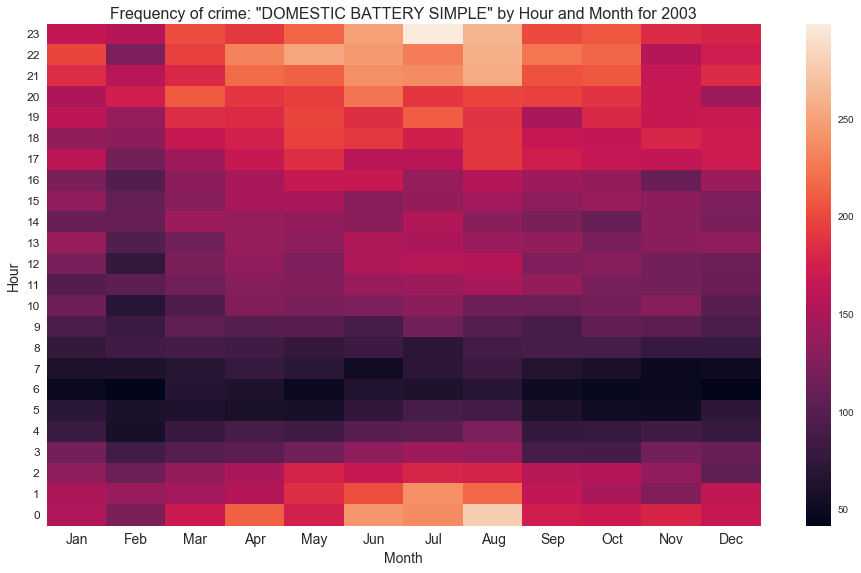

In [207]:
year = 2003
y_ax = 'Hour'
x_ax = 'Month'
x_labs = months
crime_desc = 'DOMESTIC BATTERY SIMPLE'
def plot_crime_freq_heatmap(crime_desc, x_ax, y_ax, x_labs, y_labs, year, df=chi_crimes):
    tmp = df[(df['Description'] == crime_desc) &
                     (df['Year'] == year)][['Description', y_ax, x_ax]] 
    tmp1 = tmp.pivot_table(index=y_ax, columns=x_ax, values='Description', aggfunc=['count'])
    tmp1.sort_index(ascending=False, inplace=True)
    fig, ax = plt.subplots(figsize=(16,9))
    sns.heatmap(tmp1, ax=ax, annot=False, fmt='d')
    ax.xaxis.set_ticklabels(x_labs, fontsize=14)
    ax.yaxis.set_ticklabels(y_labs, fontsize=12, rotation=0)
    ax.set_xlabel(x_ax, fontsize=14)
    ax.set_ylabel(y_ax, fontsize=14)
    ax.set_title('Frequency of crime: "{}" by {} and {} for {}'
                 .format(crime_desc, y_ax, x_ax, year), fontsize=16)
    plt.show()
    
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Month', 'Hour', months, hours, 2003)

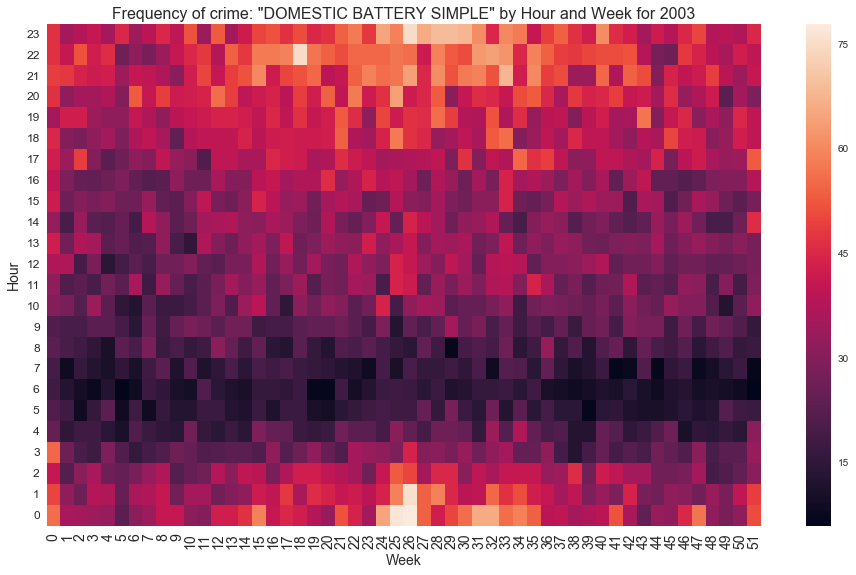

In [208]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Week', 'Hour', weeks, hours, 2003)

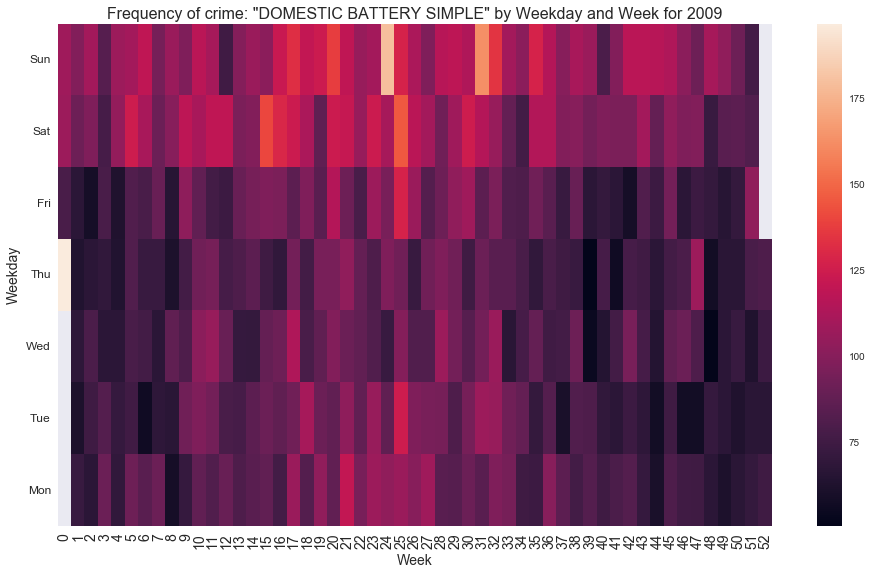

In [209]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Week', 'Weekday', weeks, weekdays, 2009)

KeyError: '2009'

In [ ]:
chi_map = folium.Map(location=[41.85, -87.6], zoom_start=11)
chi_map

In [ ]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(df_incidents.Y, df_incidents.X):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
chi_map.add_child(incidents)